# Backpack-price-prediction

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load datasets
train = pd.read_csv("train.csv")
training_extra = pd.read_csv("training_extra.csv")
test = pd.read_csv("test.csv")


In [4]:
# Merge train and training_extra
df = pd.concat([train, training_extra], ignore_index=True)

In [5]:
# Basic info
print("Training Data Info:")
df.info()
print("\nTest Data Info:")
test.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 335.2+ MB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    200000 non-null  int64  
 1   Brand                 193773 non-null  object 
 2   Materia

<Figure size 1200x600 with 0 Axes>

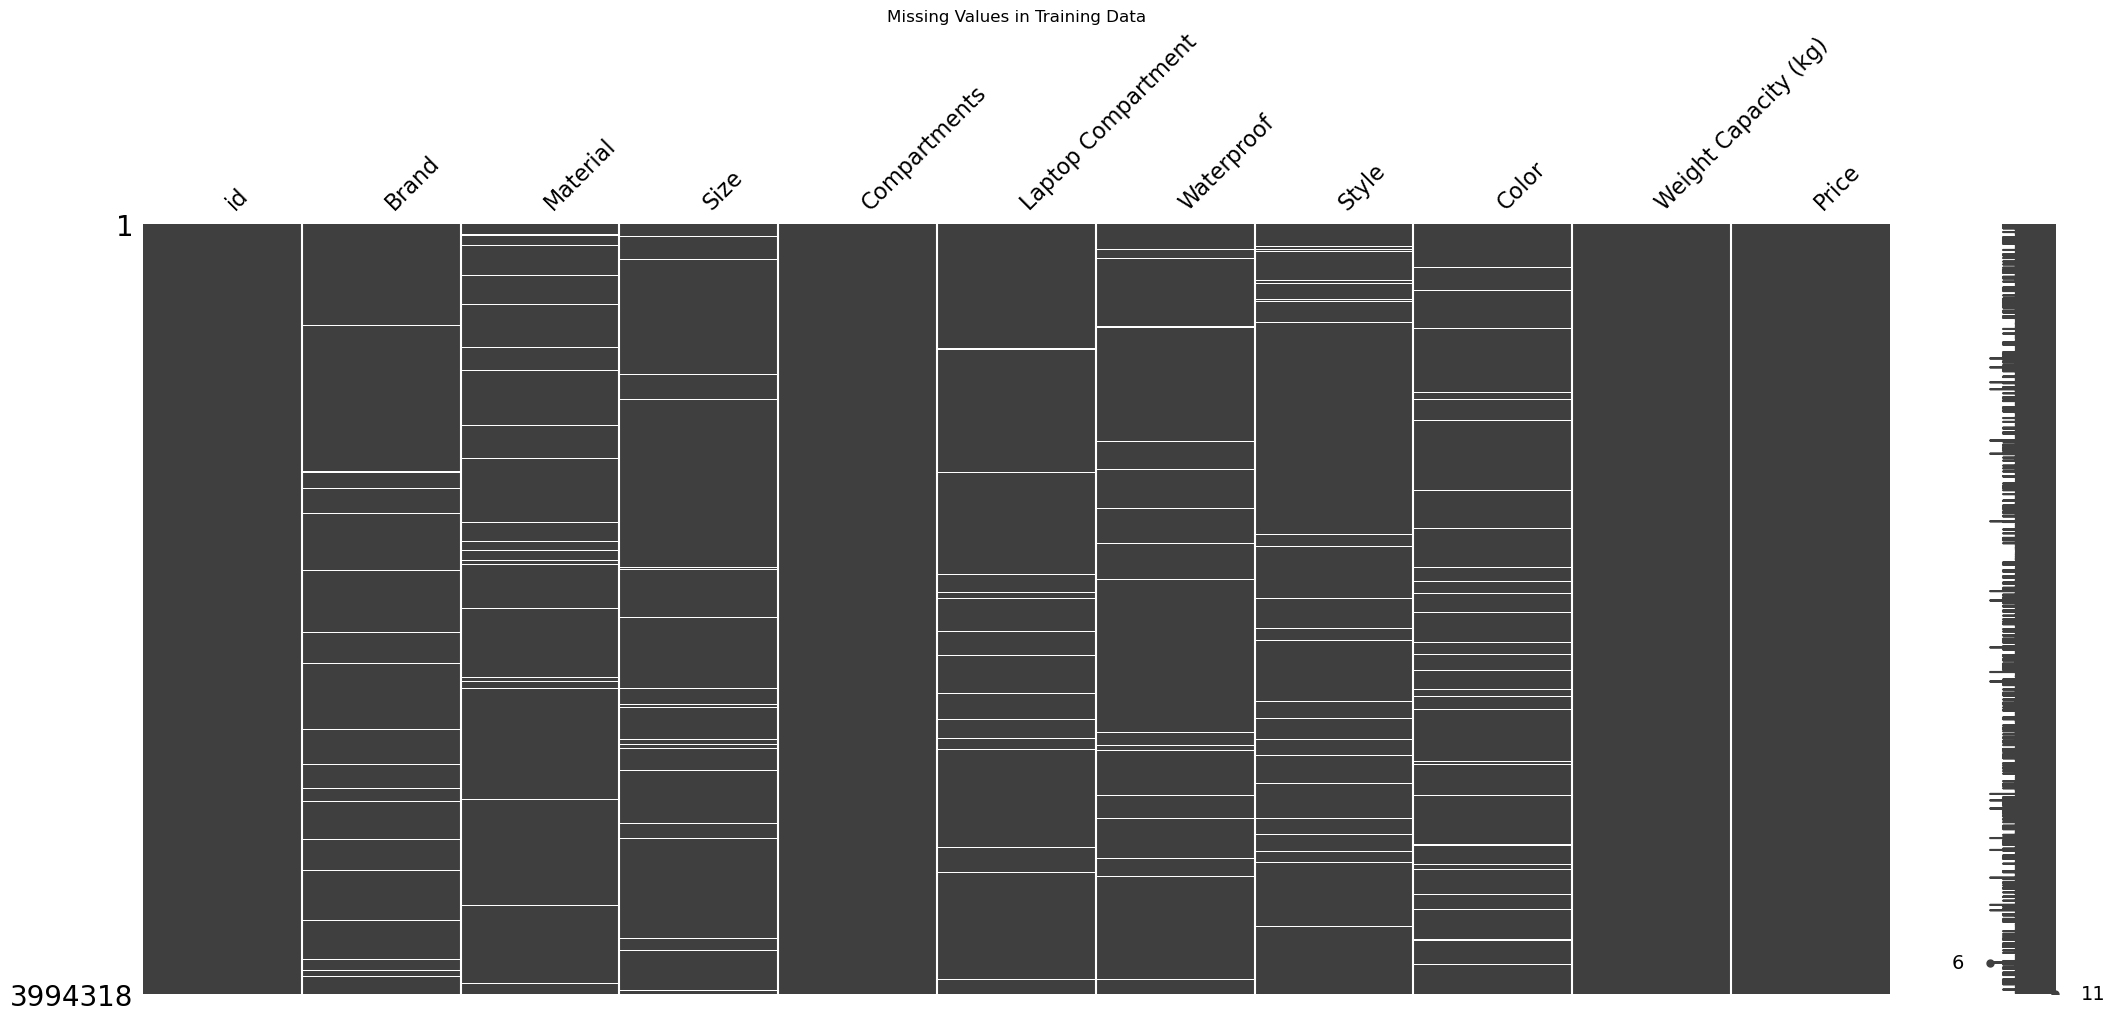

In [6]:
# Visualizing missing values
plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.title("Missing Values in Training Data")
plt.show()


In [7]:
# Checking missing values percentage
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table.columns = ['Missing Values', '% of Total Values']
    return mis_val_table[mis_val_table['Missing Values'] > 0].sort_values('% of Total Values', ascending=False)

print(missing_values_table(df))

                      Missing Values  % of Total Values
Color                         133617           3.345177
Brand                         126758           3.173458
Material                      110962           2.777996
Style                         104180           2.608205
Laptop Compartment             98533           2.466829
Waterproof                     94324           2.361454
Size                           87785           2.197747
Weight Capacity (kg)            1808           0.045264


In [8]:
# Filling missing values
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [9]:
# Remove 'Price' from numerical_cols to avoid KeyError in test dataset
if 'Price' in numerical_cols:
    numerical_cols.remove('Price')


In [10]:
# Fill missing values for categorical columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

test[categorical_cols] = test[categorical_cols].fillna(test[categorical_cols].mode().iloc[0])

In [11]:
# Impute numerical columns with median
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
test[numerical_cols] = imputer.transform(test[numerical_cols])


C:\Users\abhis\AppData\Local\Temp\ipykernel_18896\3731895791.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")


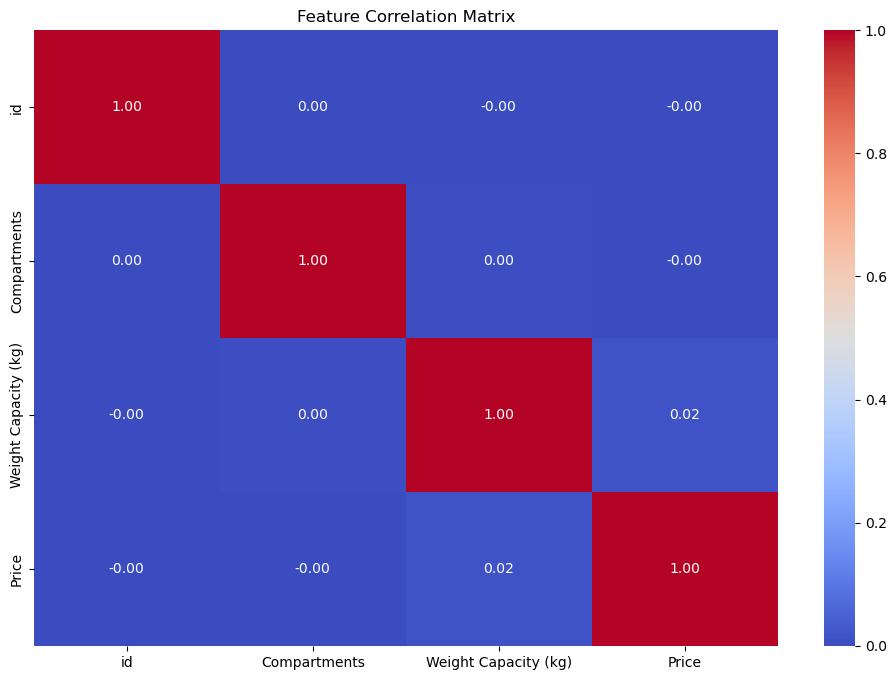

In [12]:
# Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

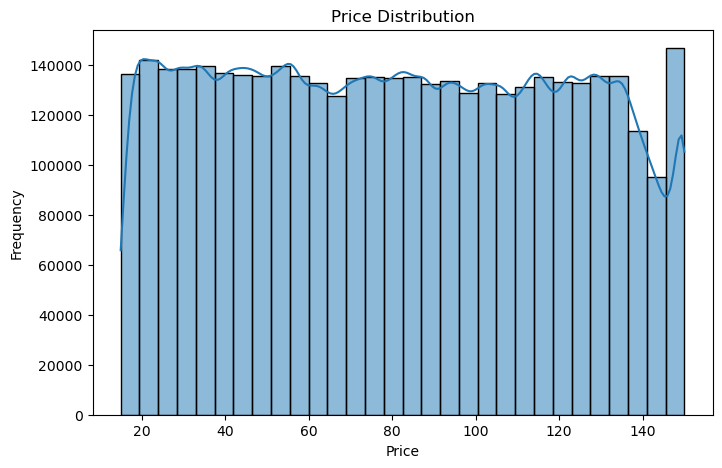

In [13]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

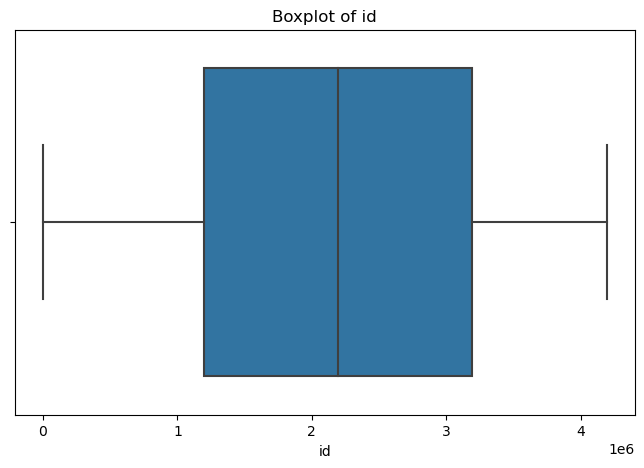

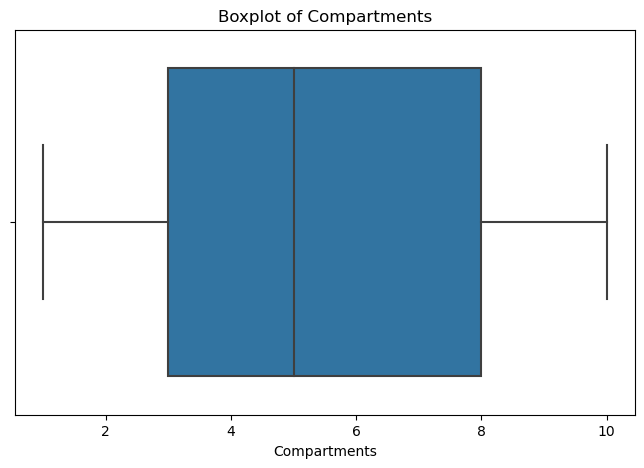

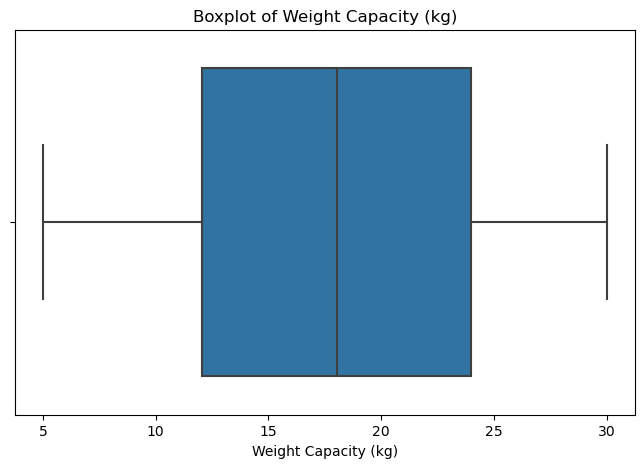

In [14]:
# Boxplots for numerical features
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

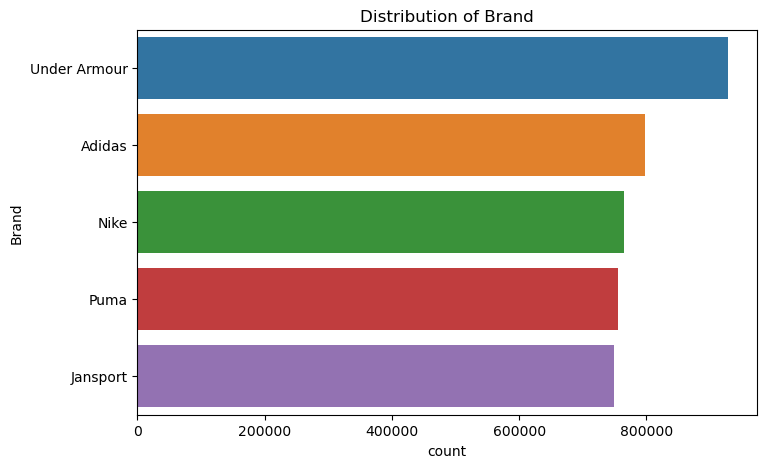

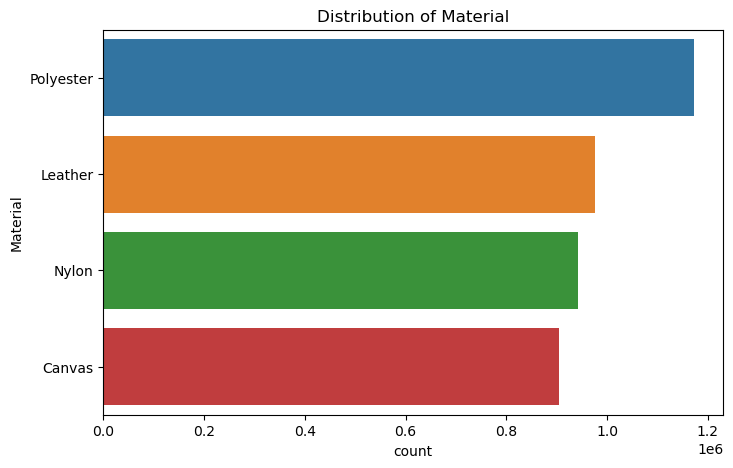

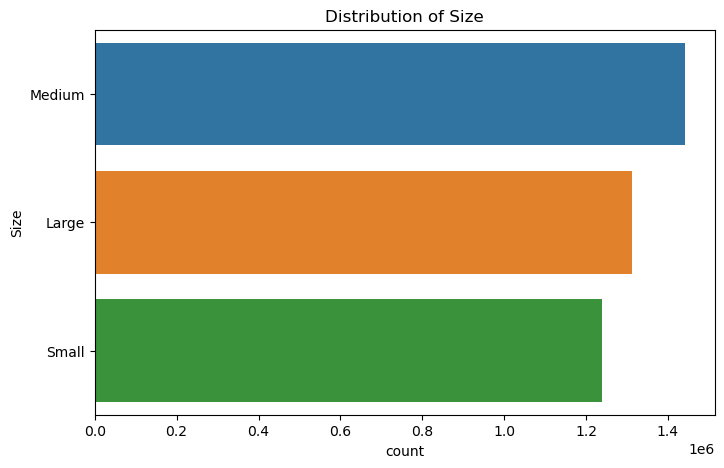

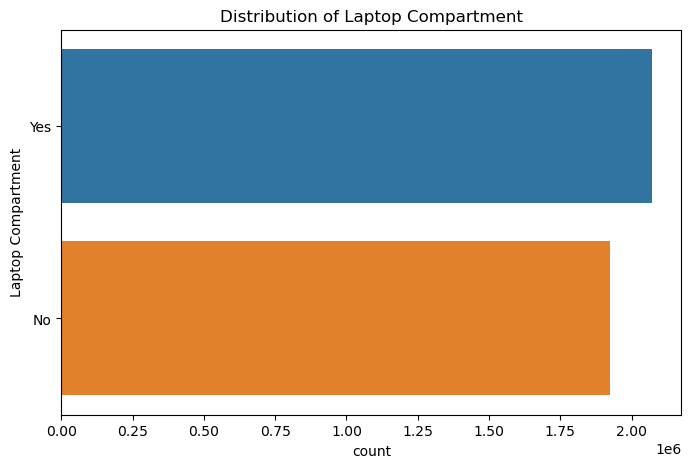

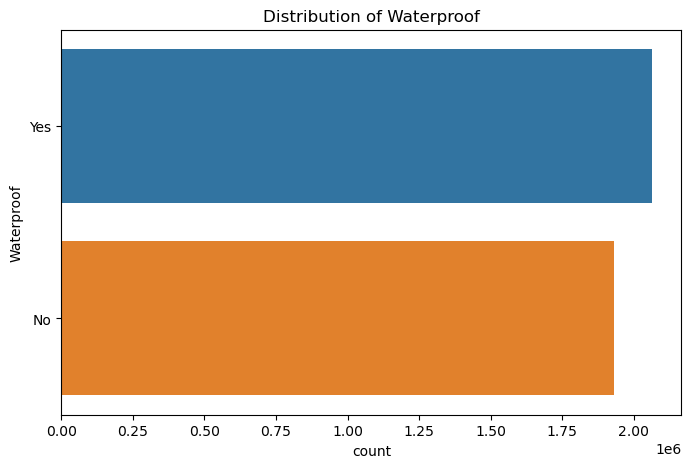

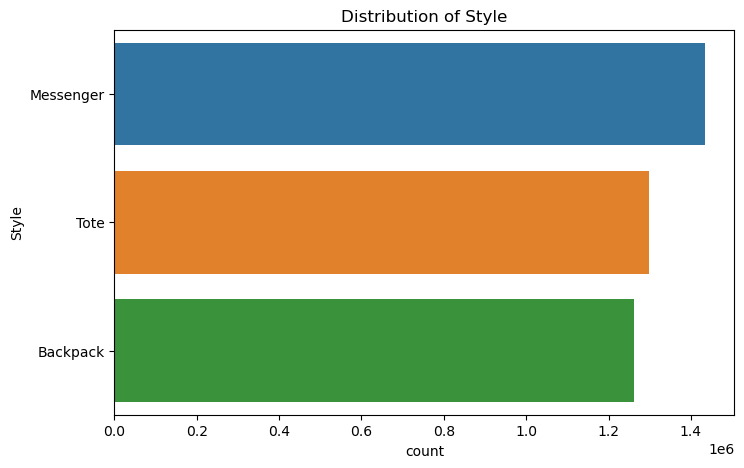

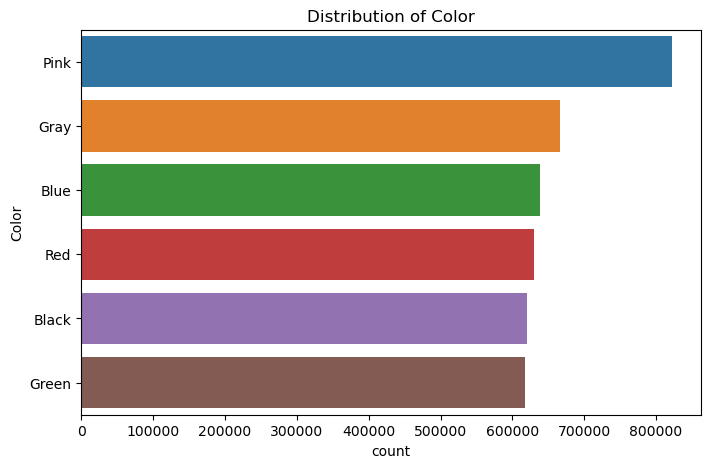

In [15]:
# Countplots for categorical features
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()


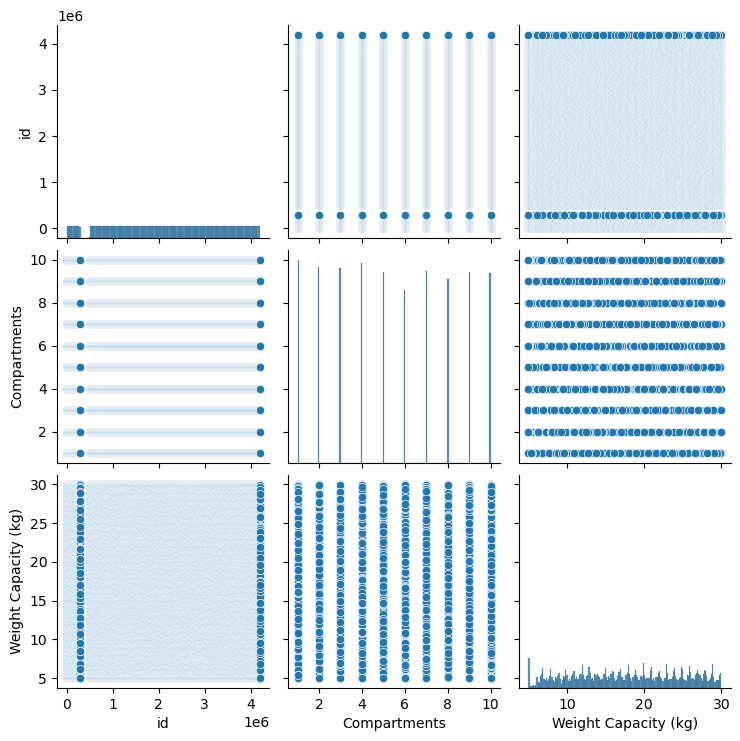

In [16]:
# Pairplot for numerical features
sns.pairplot(df[numerical_cols])
plt.show()


In [17]:
# Encoding categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [18]:
# Feature Scaling
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])


In [19]:
# Train-test split
X = df.drop(columns=['Price'])  # Using 'Price' as the target variable
y = df['Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Model training
model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
# Predictions
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.2f}")


RMSE: 38.88


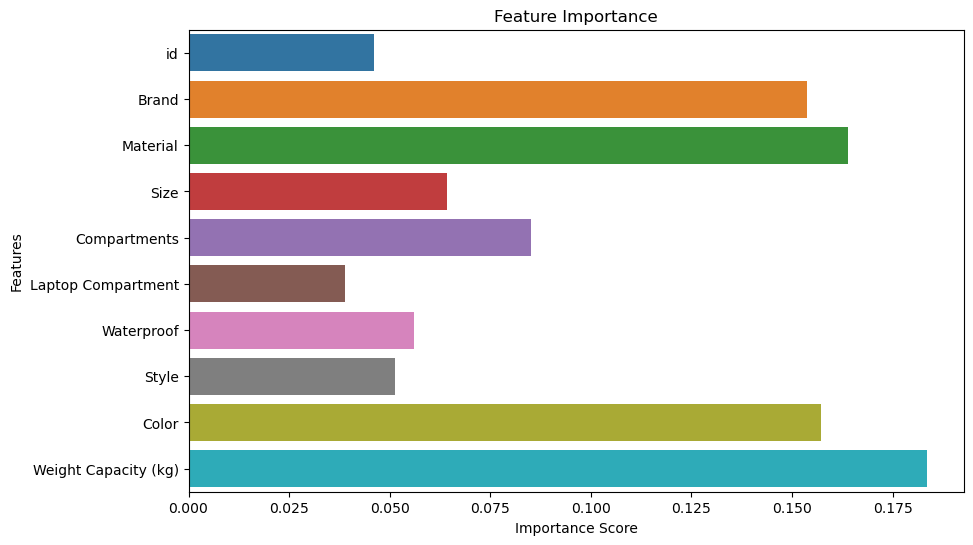

In [28]:
# Feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


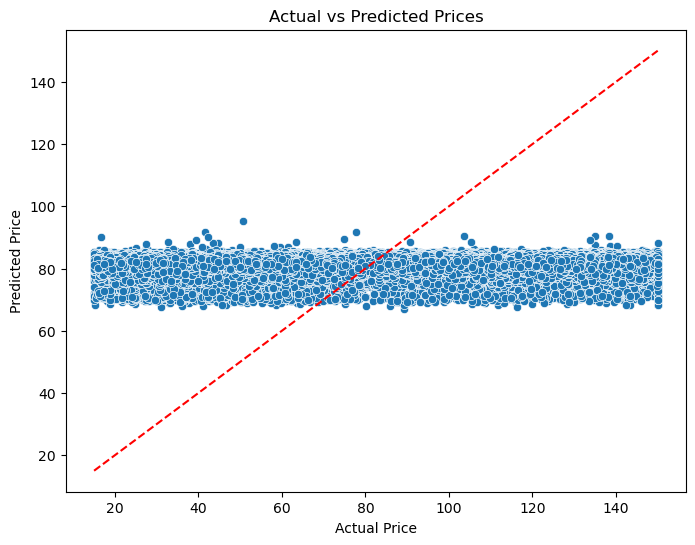

In [23]:
# Scatter plot of actual vs predicted prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Diagonal line
plt.show()


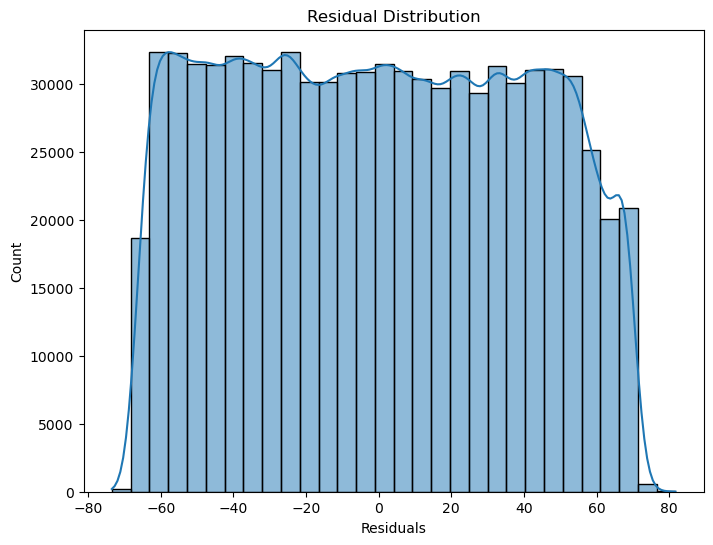

In [24]:
# Residual plot
plt.figure(figsize=(8, 6))
sns.histplot(y_val - y_pred, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.show()


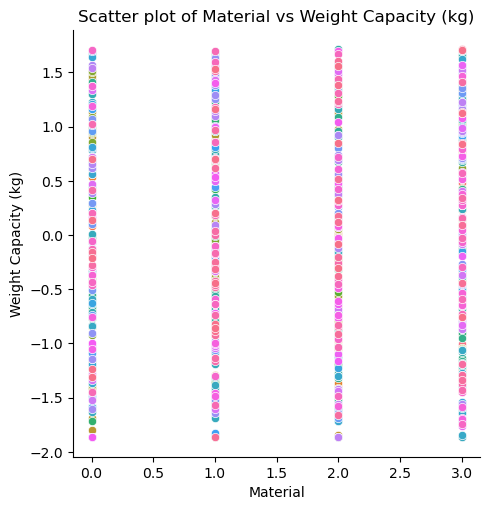

In [49]:
# Assuming you have already trained your model and have the feature importances
# Get the indices of the top 2 important features
important_indices = np.argsort(model.feature_importances_)[-2:]  # Get the indices of the top 2 features
important_features = X.columns[important_indices]  # Get the names of the top 2 features

# Downsample the DataFrame to a smaller size
sample_size = 1000  # Adjust this number based on your dataset size
sample_df = df.sample(n=sample_size, random_state=42)  # Randomly sample rows

# Use FacetGrid with the sample
sns.FacetGrid(sample_df, hue="Price", height=5).map(sns.scatterplot, important_features[0], important_features[1])
plt.title(f'Scatter plot of {important_features[0]} vs {important_features[1]}')
plt.show()

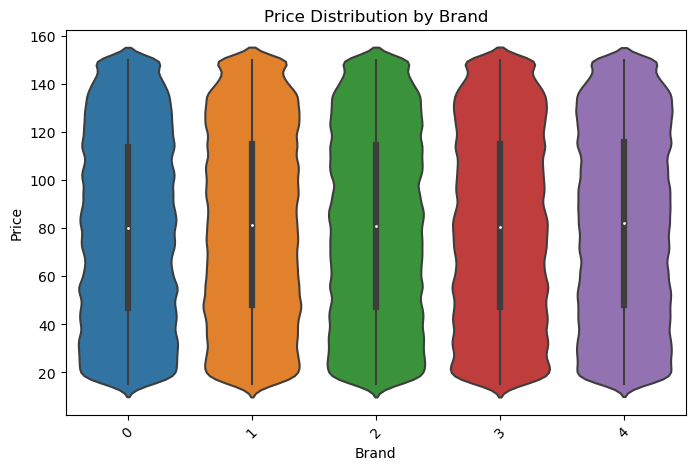

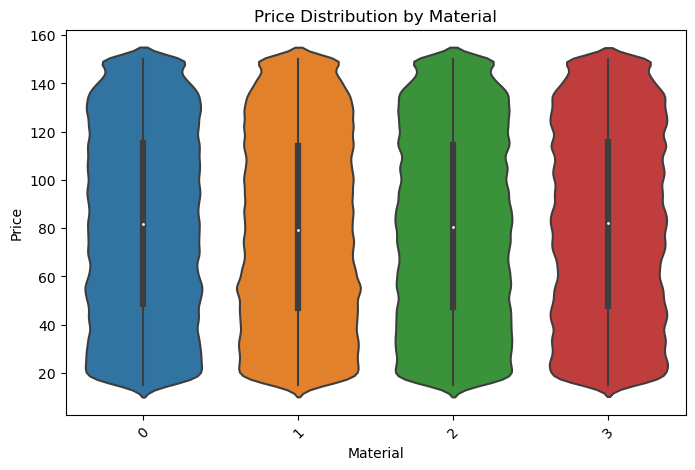

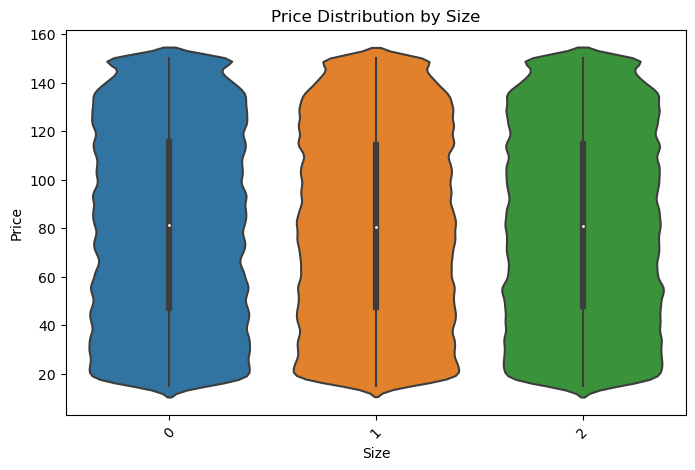

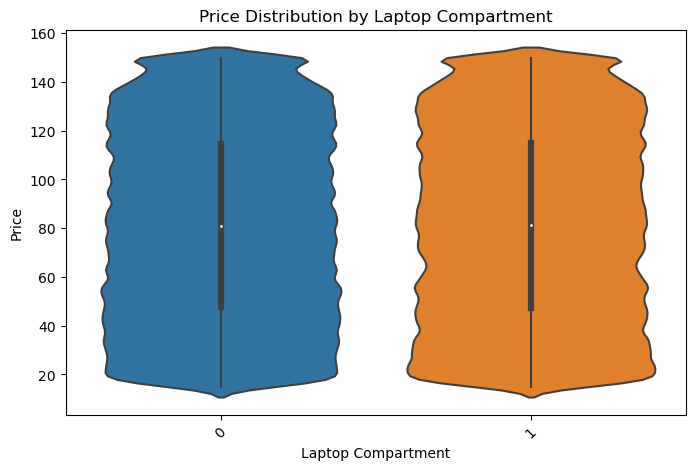

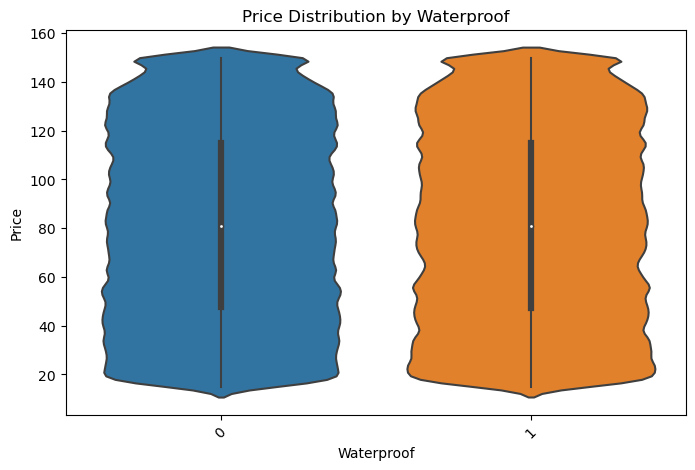

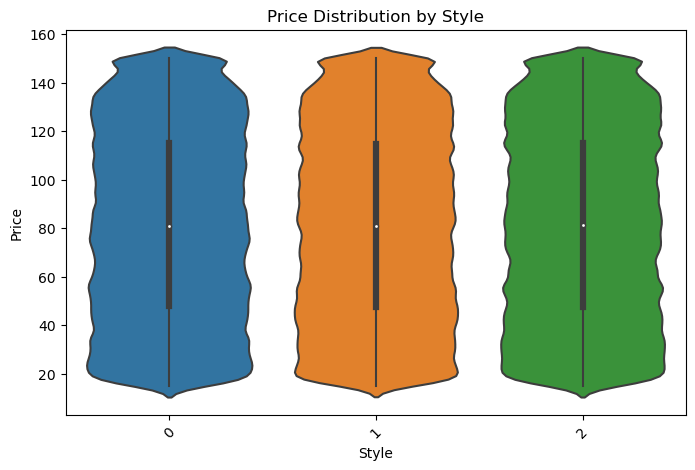

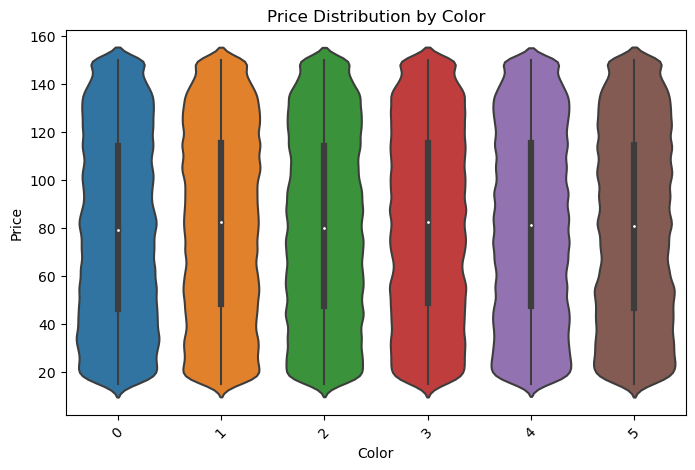

In [31]:
# Violin plots for price vs categorical features
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[col], y=df['Price'])
    plt.title(f"Price Distribution by {col}")
    plt.xticks(rotation=45)
    plt.show()

In [39]:
# Ensure test data has the same features as training data
missing_cols = set(X_train.columns) - set(test.columns)
extra_cols = set(test.columns) - set(X_train.columns)
print(f"Missing columns in test set: {missing_cols}")
print(f"Extra columns in test set: {extra_cols}")

Missing columns in test set: set()
Extra columns in test set: set()


In [40]:
# Add missing columns with default value (0 or mean strategy)
for col in missing_cols:
    test[col] = 0  # or test[col] = X_train[col].mean()

In [58]:
# Drop extra columns if needed
test = test[X_train.columns]

In [59]:
# Final predictions on test set
test_predictions = model.predict(test)
test['predicted_price'] = test_predictions
test[['id', 'predicted_price']].to_csv("submission.csv", index=False)


In [65]:

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],  # Ensure this matches the ID column in your test dataset
    'predicted_price': test_predictions  # Use the predicted prices 
})


In [63]:
# Load the test dataset again to ensure you have the correct IDs
test = pd.read_csv("test.csv")

# Check the test DataFrame to ensure IDs are correct
print(test.head())  # Print the first few rows of the test DataFrame to inspect the IDs

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],  # Ensure this matches the ID column in your test dataset
    'predicted_price': test_predictions  # Use the predicted prices
})

# Save the submission file
submission.to_csv("submission.csv", index=False)

print("Predictions saved to submission.csv")

       id   Brand Material    Size  Compartments Laptop Compartment  \
0  300000    Puma  Leather   Small           2.0                 No   
1  300001    Nike   Canvas  Medium           7.0                 No   
2  300002  Adidas   Canvas   Large           9.0                 No   
3  300003  Adidas    Nylon   Large           1.0                Yes   
4  300004     NaN    Nylon   Large           2.0                Yes   

  Waterproof      Style  Color  Weight Capacity (kg)  
0         No       Tote  Green             20.671147  
1        Yes   Backpack  Green             13.564105  
2        Yes  Messenger   Blue             11.809799  
3         No  Messenger  Green             18.477036  
4        Yes       Tote  Black              9.907953  
Predictions saved to submission.csv


In [64]:
# Load and check the submission file
submission_check = pd.read_csv("submission.csv")
print(submission_check.head())

       id  predicted_price
0  300000        81.402900
1  300001        82.040060
2  300002        82.579346
3  300003        81.238410
4  300004        78.496890


In [56]:
print("Predictions saved to submission.csv") 

Predictions saved to submission.csv
